In [4]:
import os

import numpy as np
import pandas as pd

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import matplotlib.pyplot as plt

import kagglehub

device = torch.device('cpu')
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')

In [3]:
# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

100%|██████████| 612M/612M [00:15<00:00, 42.4MB/s] 

Extracting files...


Path to dataset files: C:\Users\timon\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1


# Preprocessing

## GTSRB Dataset

In [5]:
# Dataset class for GTSRB
class GTSRBDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        
        if self.train:
            # Training data structure in GTSRB
            self.data_dir = os.path.join(root_dir, 'Train')
            self.classes = os.listdir(self.data_dir)
            self.images = []
            self.labels = []
            
            # Load all images and labels
            for class_id in self.classes:
                if not os.path.isdir(os.path.join(self.data_dir, class_id)):
                    continue
                class_dir = os.path.join(self.data_dir, class_id)
                for img_file in os.listdir(class_dir):
                    if img_file.endswith('.png'):
                        self.images.append(os.path.join(class_dir, img_file))
                        self.labels.append(int(class_id))
        else:
            # Test data structure
            self.data_dir = root_dir
            # Load CSV file with test data information
            test_csv = os.path.join(self.data_dir, 'Test.csv')
            df = pd.read_csv(test_csv, sep=',')
            self.images = [os.path.join(self.data_dir, filename) for filename in df['Path']]
            self.labels = df['ClassId'].values
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

## Data Loaders

In [10]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

test_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

# Create datasets and data loaders
def get_data_loaders(root_dir, batch_size=64):
    train_dataset = GTSRBDataset(root_dir=root_dir, train=True, transform=train_transforms)
    test_dataset = GTSRBDataset(root_dir=root_dir, train=False, transform=test_transforms)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    return train_dataset, train_loader, test_dataset, test_loader

# Custom CNN Model

In [7]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=43):  # GTSRB has 43 classes
        super(TrafficSignCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fourth convolutional block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)
        
        # Fully connected layers - assuming input images are 32x32
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Block 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Block 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Block 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Block 4
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # Flatten
        x = x.view(-1, 256 * 2 * 2)
        
        # Fully connected with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

# Evaluation

Epoch 1/20:
Train Loss: 1.5307, Val Loss: 0.5487, Accuracy: 81.68%
Epoch 2/20:
Train Loss: 0.3862, Val Loss: 0.2507, Accuracy: 91.73%
Epoch 3/20:
Train Loss: 0.2154, Val Loss: 0.2022, Accuracy: 93.63%
Epoch 4/20:
Train Loss: 0.1571, Val Loss: 0.1852, Accuracy: 94.59%
Epoch 5/20:
Train Loss: 0.1192, Val Loss: 0.1767, Accuracy: 94.97%
Epoch 6/20:
Train Loss: 0.1057, Val Loss: 0.2355, Accuracy: 93.67%
Epoch 7/20:
Train Loss: 0.0886, Val Loss: 0.1894, Accuracy: 95.03%
Epoch 8/20:
Train Loss: 0.0907, Val Loss: 0.1931, Accuracy: 94.97%
Epoch 9/20:
Train Loss: 0.0770, Val Loss: 0.1561, Accuracy: 96.38%
Epoch 10/20:
Train Loss: 0.0698, Val Loss: 0.1306, Accuracy: 96.11%
Epoch 11/20:
Train Loss: 0.0574, Val Loss: 0.1157, Accuracy: 97.06%
Epoch 12/20:
Train Loss: 0.0661, Val Loss: 0.1463, Accuracy: 96.06%
Epoch 13/20:
Train Loss: 0.0589, Val Loss: 0.1177, Accuracy: 96.66%
Epoch 14/20:
Train Loss: 0.0506, Val Loss: 0.1420, Accuracy: 96.90%
Epoch 15/20:
Train Loss: 0.0454, Val Loss: 0.1305, Accura

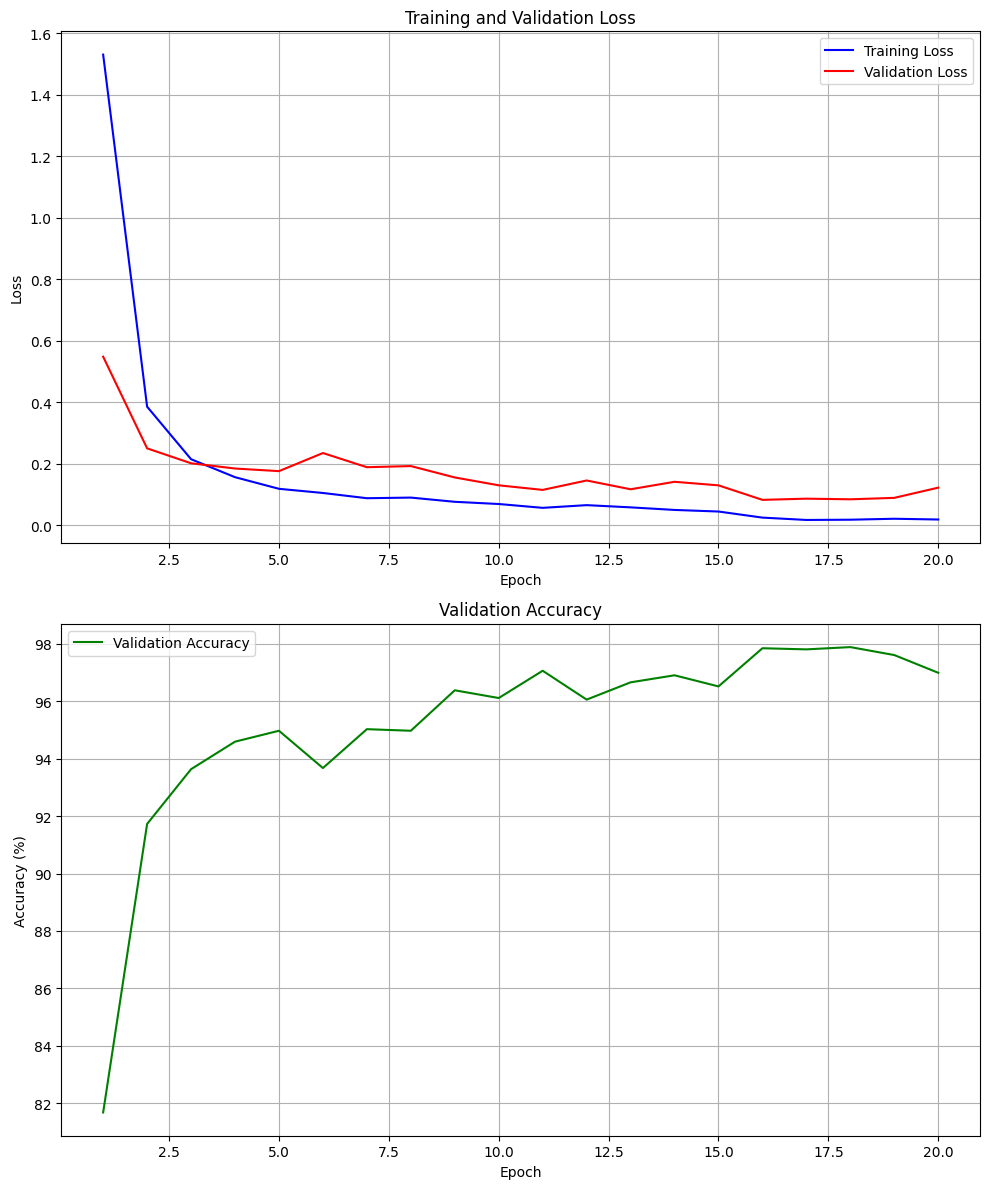

In [18]:
def train_model(model, train_loader, test_loader, epochs=20, learning_rate=0.001):
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    
    best_accuracy = 0.0
    
    # Lists to store loss values for plotting
    train_losses = []
    val_losses = []
    accuracies = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)  # Save train loss
        
        # Validation phase
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(test_loader.dataset)
        val_losses.append(val_loss)  # Save validation loss
        
        accuracy = 100 * correct / total
        accuracies.append(accuracy)  # Save accuracy
        
        # Adjust learning rate
        scheduler.step(val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')
        
        # Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_traffic_sign_model.pth')
        
        # Save checkpoint for each epoch if needed
        torch.save(model.state_dict(), f'traffic_sign_model_epoch_{epoch+1}.pth')
    
    print(f'Best Accuracy: {best_accuracy:.2f}%')
    
    # Plot training and validation loss
    plot_training_history(train_losses, val_losses, accuracies, epochs)
    
    return model, train_losses, val_losses, accuracies

def plot_training_history(train_losses, val_losses, accuracies, epochs):
    """
    Plot the training and validation loss along with accuracy
    
    Args:
        train_losses: List of training losses
        val_losses: List of validation losses
        accuracies: List of validation accuracies
        epochs: Number of training epochs
    """
    import matplotlib.pyplot as plt
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Epochs as x-axis values (starting from 1)
    epoch_range = list(range(1, epochs + 1))
    
    # Plot losses
    ax1.plot(epoch_range, train_losses, 'b-', label='Training Loss')
    ax1.plot(epoch_range, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(epoch_range, accuracies, 'g-', label='Validation Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Path should be where you unzipped the Kaggle dataset
dataset_path = path  # Use the path from kagglehub
    
# Get data loaders
train_dataset, train_loader, test_dataset, test_loader = get_data_loaders(dataset_path)
    
# Create model
model = TrafficSignCNN()
    
# Train the model
trained_model, train_losses, val_losses, accuracies = train_model(model, train_loader, test_loader)

In [13]:
def evaluate_model_checkpoint(model_class, checkpoint_path, test_loader, test_dataset, batch_size=64):
    """
    Evaluate a model checkpoint on the test dataset.
    
    Args:
        model_class: The model architecture class to use
        checkpoint_path: Path to the saved model checkpoint (.pth file)
        test_image_dir: Directory containing the test images
        batch_size: Batch size for testing
    
    Returns:
        The test accuracy
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create test dataset and dataloader
    test_transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Assuming your dataset follows a structure like:
    # test_image_dir/class_id/image.jpg
    
    # Create and load the model
    model = model_class()
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model = model.to(device)
    model.eval()
    
    # Evaluate the model
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test accuracy on {total} images: {accuracy:.2f}%')
    
    
    
    return accuracy

# Example usage:
# evaluate_model_checkpoint(TrafficSignCNN, 'best_traffic_sign_model.pth', 'dataset/images/test')

In [14]:
train_dataset, train_loader, test_dataset, test_loader = get_data_loaders(dataset_path)

In [17]:
evaluate_model_checkpoint(TrafficSignCNN, 'best_traffic_sign_model_7.pth', test_loader, test_dataset)

Test accuracy on 12630 images: 96.31%


96.31037212984957